In [1]:
## packages' import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import scipy.linalg as la

## WARNING

Theory requires the assumption of domain separability in every of the theoretical cases. 

## Adaptive Partial Minimization

### (non-)separable components: 

$f(x) = min_{u \in U}\, \underbrace{F(x) + \mathcal{F}(u) + \tilde{\Psi}(x,u)}_{\Psi(x,u)}$, $a(x)$ eventual regularizer

### 1 : Strong-convexity imbalance (middle aux, bad full, small dimension)

$F$ endowed with a $(\mu_F,L_F,\delta_F)$ first-order inexact oracle

$\mathcal{F} \in \mathcal{S}^{1,1}_{\mu_{\mathcal{F}},L_{\mathcal{F}}}(U)$

$\tilde{\Psi} \in \mathcal{S}^{1,1}_{\mu_c,L_c}(Q\times U)$

yields a $((\mu_F+\mu_c,L_F+L_c),(\mu_{\mathcal{F}}+\mu_c,L_{\mathcal{F}}+L_c),\delta_F)$ joint first-order inexact oracle for $\Psi$ and for every $x \in Q$, $\Psi(x,\cdot)$ is in $\mathcal{S}^{1,1}_{\mu_{\mathcal{F}}+\mu_c,L_{\mathcal{F}}+L_c}(U)$.

On the other hand for $\Psi$ itselfs without considering any split one can say that we enjoy of a $(\mu_c,\text{max}\{L_F,L_{\mathcal{F}}\}+L_c)$ first-order inexact oracle

Two major aspects here.

1) conditioning gain $ \kappa_{x} = \frac{\mu_F + \mu_c}{L_F + L_c}$ vs. $ \kappa_{\text{full}} = \frac{\mu_c}{\text{max}\{L_F,L_{\mathcal{F}}\}+L_c}$ $\Rightarrow \kappa_{\text{gain}} = \frac{\mu_F+\mu_c}{\mu_c}\,\frac{L_c+\text{max}\{L_F+L_{\mathcal{F}}\}}{L_F+L_c}$ for the differentiation with plain methods
                          
2) difficulty of aux $ \kappa_{a} = \frac{\mu_{\mathcal{F}}+\mu_c}{L_{\mathcal{F}}+L_c} $ for the differentiation with fixed oracle accuracy

In [2]:
## dimensional set-up
pre_prop = 0.95
pre_d = 1000
dy = 10000
dx = int(np.ceil(pre_prop*pre_d)+2)
du = int(pre_d-dx+2)
d = dx+du

## size of domains 
multi = 5
H_Q = np.sqrt(dx)*multi
H_U = np.sqrt(du)
H_base = np.sqrt(H_Q**2 + H_U**2)

## parameters

delta_F = 0
mu_F = 2e-3
L_F = 1

mu_F_bis = 1e-5
L_F_bis = 1

mu_c = 0
L_c = 1

L_x_practice = L_F+L_c
mu_x_practice = mu_F + mu_c
kappa_x_practice =  mu_x_practice/L_x_practice

L_u_practice = L_F_bis + L_c
mu_u_practice = mu_F_bis + mu_c
kappa_u_practice = mu_u_practice/L_u_practice

# no extra information embedded
L_a_practice = L_u_practice
mu_a_practice = mu_u_practice
kappa_a_practice = kappa_u_practice

L_base_practice = np.max([L_F,L_F_bis]) + L_c
mu_base_practice = mu_c
kappa_base_practice = mu_base_practice/L_base_practice

if kappa_base_practice>0:
    kappa_gain = kappa_x_practice/kappa_base_practice
else:
    kappa_gain = 'non available'

In [3]:
kappa_x_practice

0.001

In [4]:
kappa_base_practice 

0.0

In [5]:
H_base**2 * L_base_practice / 2

23850.000000000007

In [6]:
kappa_a_practice

5e-06

In [7]:
kappa_gain

'non available'

In [8]:
## oracle cost model (FGD used to solve inner problem smooth convex)
oracle_K,oracle_beta,oracle_r = dx,du*H_U*np.sqrt(2*L_a_practice),1/2
oracle_cost = lambda eta: np.sum(oracle_K*np.ones(len(eta)) + oracle_beta/eta**oracle_r)

## cost for full 
oracle_np_K,oracle_np_beta,oracle_np_r = d,0,1
oracle_np_cost = lambda eta: len(eta)*oracle_np_K

if kappa_a_practice>0:
    ## oracle cost model 2 (FGD used to solve inner problem smooth strongly convex)
    oracle_K2,oracle_beta2 = dx+du*np.log(L_a_practice*H_U**2 / 2)/np.log(1+np.sqrt(kappa_a_practice)),du/np.log(1+np.sqrt(kappa_a_practice))
    oracle_cost2 = lambda eta: np.sum(oracle_K2*np.ones(len(eta)) - oracle_beta2*np.log(eta))

## delta cost model
delta_h,delta_s = 1/2 * np.sqrt(8*H_U**2*L_a_practice), 1/2
delta_cost = lambda eta: delta_h/delta_s * eta**delta_s + delta_F
delta_np_h,delta_np_s = 0,1
delta_np_cost = lambda eta: delta_np_h/delta_np_s * eta**delta_np_s + delta_F

In [9]:
## solve (I)

def solve_I_instance1_constant(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                               mode='GD',inexact_update_lb=0,disp=False,debug=False):
    feasible = True
    
    N = int(N_float)
    
    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
        else:
            q = np.ones(N)/N
        q_tilde = q
        convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N]) 
        
    delta_cost = lambda eta: h/s * eta**s + delta_F
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
        
        eta_schedule = ((Gamma_N_eps-min_inexact_updates)/np.sum(q) * s/h)**(1/s) * np.ones(N)
    
        if disp:
            print('KKT solved:: Na = 0, Nb = 0')
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
        
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

def solve_I_instance1(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                      mode='GD',inexact_update_lb=0,disp=False,debug=False):
    
    feasible = True
    
    N = int(N_float)

    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
            convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
        else:
            q = np.ones(N)/N
            convergence_term = L*R**2/2 / N
        q_tilde = q
        
    delta_cost = lambda eta: h/s * eta**s + delta_F
    Phi = lambda Na,Nb: np.sum(delta_cost(lb)*q[:Nb]) + np.sum(delta_cost(la)*q[N+1-Na:]) 
    Chi = lambda Na,Nb: np.sum(h/s*(r*beta/h)**(s/(r+s))*q[Nb:N-Na]**(r/(r+s)))
    bar_lambda = lambda Na,Nb: ((Gamma_N_eps - Phi(Na,Nb))/Chi(Na,Nb))**(-(r+s)/s)
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    trivial = True
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
    
        # check KKT (start with Na = 0 in order to speed up things as in my cases, Na = 0 is the right choice)
        for Na in np.arange(N):
            for Nb in np.arange(N-Na):
                bar_lambda_proposal = bar_lambda(Na,Nb)
                check = True 
                if debug: 
                    print('Na = '+str(Na)+' || Nb = '+str(Nb))
                if Na>0:
                    check = check and bar_lambda_proposal>=(r*beta)/(q[N-Na]*h*la**(r+s))
                if Nb>0:
                    check = check and bar_lambda_proposal<=(r*beta)/(q[Nb-1]*h*lb**(r+s))
                check = check and bar_lambda_proposal<(r*beta)/(q[N-Na-1]*h*la**(r+s))
                check = check and bar_lambda_proposal>(r*beta)/(q[Nb]*h*lb**(r+s))
                if check:
                    trivial = False
                    Na_final,Nb_final,bar_lambda_final = Na,Nb,bar_lambda_proposal
                    if disp:
                        print('KKT solved:: Na = '+str(Na_final)+', Nb = '+str(Nb_final)+', bar lambda = '+str(bar_lambda_final))
                    break
            if check:
                break

        if trivial:
            if disp:
                print('trivial solution')
            eta_schedule =  np.ones(N)*lb
        else:
            eta_schedule = np.concatenate((np.ones(Nb)*lb,((r*beta)/(bar_lambda_final*q[Nb:N-Na]*h))**(1/(r+s)),np.ones(Na_final)*la))
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
    
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

## solve (2)

def solve_I_instance2_constant(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                               mode='GD',inexact_update_lb=0,disp=False,debug=False):
    feasible = True
    
    N = int(N_float)
    
    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
        else:
            q = np.ones(N)/N
        q_tilde = q
        convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N]) 
        
    delta_cost = lambda eta: h/s * eta**s + delta_F
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
        
        eta_schedule = ((Gamma_N_eps-min_inexact_updates)/np.sum(q) * s/h)**(1/s) * np.ones(N)
    
        if disp:
            print('KKT solved:: Na = 0, Nb = 0')
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
        
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible

def solve_I_instance2(epsilon_target,N_float,kappa,L,R,beta,r,h,s,la,lb,\
                      mode='GD',inexact_update_lb=0,disp=False,debug=False):
    
    feasible = True
    
    N = int(N_float)

    if mode=='FGD':
        if kappa>0:
            v = 1/(1+np.sqrt(kappa))
            convergence_term = L*R**2/2 * v**(N-1)
            q = v**(N-1-np.arange(N))
            q_tilde = v**N + q
        else:
            convergence_term = 2*L*R**2 / N**2 # approx
            q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1/N**2 + q
    else:
        if kappa>0:
            v = (1-kappa)
            q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
            convergence_term = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
        else:
            q = np.ones(N)/N
            convergence_term = L*R**2/2 / N
        q_tilde = q
        
    delta_cost = lambda eta: h/s * eta**s + delta_F
    Phi = lambda Na,Nb: np.sum(delta_cost(lb)*q[:Nb]) + np.sum(delta_cost(la)*q[N+1-Na:]) 
    Chi = lambda Na,Nb: np.sum((beta/s)*np.ones(len(q[Nb:N-Na])))
    bar_lambda = lambda Na,Nb: ((Gamma_N_eps - Phi(Na,Nb))/Chi(Na,Nb))**(-1)
    
    Gamma_N_eps = epsilon_target - convergence_term
    min_delta = np.sum(q*delta_cost(la))
    min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
    
    if disp:
        print('Gamma N eps = '+str(Gamma_N_eps)+' || min delta = '+str(min_delta)+\
              ' + min inexact updates = '+str(min_inexact_updates)+' = '+str(min_delta+min_inexact_updates))
    
    trivial = True
    
    if Gamma_N_eps>min_delta+min_inexact_updates:
    
        # check KKT (start with Na = 0 in order to speed up things as in my cases, Na = 0 is the right choice)
        for Na in np.arange(N):
            for Nb in np.arange(N-Na):
                bar_lambda_proposal = bar_lambda(Na,Nb)
                check = True 
                if debug: 
                    print('Na = '+str(Na)+' || Nb = '+str(Nb))
                if Na>0:
                    check = check and bar_lambda_proposal>=(beta)/(q[N-Na]*h*la**(s))
                if Nb>0:
                    check = check and bar_lambda_proposal<=(beta)/(q[Nb-1]*h*lb**(s))
                check = check and bar_lambda_proposal<(beta)/(q[N-Na-1]*h*la**(s))
                check = check and bar_lambda_proposal>(beta)/(q[Nb]*h*lb**(s))
                if check:
                    trivial = False
                    Na_final,Nb_final,bar_lambda_final = Na,Nb,bar_lambda_proposal
                    if disp:
                        print('KKT solved:: Na = '+str(Na_final)+', Nb = '+str(Nb_final)+', bar lambda = '+str(bar_lambda_final))
                    break
            if check:
                break

        if trivial:
            if disp:
                print('trivial solution')
            eta_schedule =  np.ones(N)*lb
        else:
            eta_schedule = np.concatenate((np.ones(Nb)*lb,((beta)/(bar_lambda_final*q[Nb:N-Na]*h))**(1/(s)),np.ones(Na_final)*la))
    
    else:
        if disp:
            print('infeasible')
        eta_schedule = np.zeros(N)*la 
        feasible = False
    
    if disp:
        print('mean eta: '+str(np.mean(eta_schedule)))
        
    return eta_schedule,feasible
    
    
def BF_I_instance_eff_update(solver,method,cost,epsilon_target,kappa,L,R,beta,r,h,s,la,lb,\
                   mode='GD',inexact_update_lb=0,debug=False):
    
    rate_search = 1.15*1.035
    rate_backtrack = 1.035
    limit_linsearch = 50
    N = 1
    init_cost = np.inf
    results_N,results_cost = [],[]
    feasible = False
    N_low,N_up = 1,np.inf
    N_max = 5e7
    
    while feasible==False and N<N_max:
        
        if mode=='GD':
            N = int(2*N)
        else:
            N = int(1.15*(N+1))
            
        _,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)
            
        if debug:
            print('current N : '+str(N)+' , feasible ? '+str(feasible))
            
        if feasible:
            N_up = N
        else:
            N_low = N
            
    if debug:
        print('bisection entered')
            
    # bisection 
    
    if N_up<N_max:
        
        slack = N_up-N_low

        while slack>1:

            N = int(np.floor((N_up+N_low)/2))

            _,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)

            if debug:
                print('current N : '+str(N)+' , feasible ? '+str(feasible))

            if feasible:
                N_up = N
            else:
                N_low = N

            slack = N_up-N_low
        
        if slack==1:
            _,feasible = solver(epsilon_target,N_low,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)
            if feasible:
                N_start = int(N_low)
            else:
                N_start = int(N_up)
        else:
            N_start = int(N_up)
        
        print('first minimal N = '+str(N_start))
                
        N_start_momentum = N_start
        N_stop = N_max
        slack_final = N_stop-N_start_momentum
        accumulator = False
            
        while slack_final>limit_linsearch and accumulator==False:
            
            rate_search = np.max([1.0005,rate_search/rate_backtrack])
            cond_upper = False
            N = N_start_momentum
            ref_eta_sched,_ = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)
            ref_cost = cost(ref_eta_sched)
            
            if debug:
                print('new loop at rs = '+str(rate_search))
                print('minimal N = '+str(N_start_momentum)+' , maximal N = '+str(N_stop))
        
            while cond_upper==False:

                N_prev = N
                N = int(rate_search*N + 1)

                eta_sched,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)

                if feasible: 
                    new_cost = cost(eta_sched)
                    if debug:
                        print('let us investigate N = '+str(N)+' , N momentum = '+str(N_start_momentum)+' | cost = '+str(new_cost))
                    if new_cost<ref_cost:
                        N_start_momentum = N_prev
                        ref_cost_momentum = ref_cost
                        ref_cost = new_cost
                    else:
                        cond_upper = True
                        ref_cost_up = new_cost
                        N_stop = N
                else:
                    if debug:
                        print('not feasible anymore => backtrack')
                    N = N_prev
                    rate_search = rate_search/rate_backtrack 
                    
            new_slack_final = N_stop-N_start_momentum
            accumulator = slack_final==new_slack_final
            if debug and accumulator:
                print('=> accumulation !')
            slack_final = new_slack_final
            
        print('best minimal N = '+str(N_start_momentum)+' , best maximal N = '+str(N_stop))
        
        for N_elem in np.arange(N_start_momentum,N_stop+1):
            
            N = int(N_elem)

            eta_sched,feasible = solver(epsilon_target,N,kappa,L,R,beta,r,h,s,la,lb,mode,inexact_update_lb)

            if feasible: # should be okay always though :) 
                new_cost = cost(eta_sched)
                results_N.append(N)
                results_cost.append(new_cost)
                if new_cost<=init_cost:
                    init_cost = new_cost
                    eta_sched_lock = eta_sched
                    N_lock = N
                else:
                    print('break: opt suspected at N = '+str(N_lock))
                    break
                    
        print('process over')

        return eta_sched_lock,N_lock,np.array(results_N),np.array(results_cost)
    
    else: 
        
        print(' maybe not feasible... too many outer iterations')
        
        return np.zeros(1),1,1,np.inf


def BF_I_full(epsilon_target,kappa,L,R,mode='FGD',inexact_update_lb=0,debug=False):
    
    N = 1
    N_lock = N
    cond = True
    N_low,N_up = 1,np.inf
    N_max = 5e8
    
    while cond and N<N_max:
        
        if mode=='GD':
            N = int(2*N)
        else:
            N = int(1.15*(N+1))
        
        if mode=='FGD':
            if kappa>0:
                v = 1/(1+np.sqrt(kappa))
                proposal = L*R**2/2 * v**(N-1)
                q = v**(N-1-np.arange(N))
                q_tilde = v**N + q
            else:
                proposal = 2*L*R**2 / N**2 # approx
                q = (np.arange(N)+1)**2 / N**2
                q_tilde = 1/N**2 + q
        else:
            if kappa>0:
                v = (1-kappa)
                q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
                proposal = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
            else:
                q = np.ones(N)/N
                proposal = L*R**2/(2*N)
            q_tilde = q
            
        min_inexact_updates = np.sum(q_tilde*inexact_update_lb)
        fixed_term = np.sum(q*delta_F)
            
        if debug:
            print('current N : '+str(N)+' , Gamma N eps = '+str(epsilon_target-proposal)+\
              ' , min inexact updates = '+str(min_inexact_updates)+' and full oracle delta impact = '+str(fixed_term))
            
        if min_inexact_updates+proposal+fixed_term<epsilon_target:
            N_up = N
            cond = False
        else:
            N_low = N
            
    if N_up < N_max:
            
        # bisection

        slack = N_up-N_low


        while slack>1:

            N = int(np.floor((N_up+N_low)/2))

            if mode=='FGD':
                if kappa>0:
                    v = 1/(1+np.sqrt(kappa))
                    proposal = L*R**2/2 * v**(N-1)
                    q = v**(N-1-np.arange(N))
                else:
                    proposal = 2*L*R**2 / N**2 # approx
                    q = (np.arange(N)+1)**2 / N**2
                q_tilde = 1+q
            else:
                if kappa>0:
                    v = (1-kappa)
                    q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
                    proposal = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
                else:
                    q = np.ones(N)/N
                    proposal = L*R**2/(2*N)
                q_tilde = q

            min_inexact_updates = np.sum(q_tilde*inexact_update_lb)

            if min_inexact_updates+proposal+fixed_term<epsilon_target:
                N_up = N
                cond = False
            else:
                N_low = N

            slack = N_up-N_low
            
        N = N_low
            
        if mode=='FGD':
            if kappa>0:
                v = 1/(1+np.sqrt(kappa))
                proposal = L*R**2/2 * v**(N-1)
                q = v**(N-1-np.arange(N))
            else:
                proposal = 2*L*R**2 / N**2 # approx
                q = (np.arange(N)+1)**2 / N**2
            q_tilde = 1+q
        else:
            if kappa>0:
                v = (1-kappa)
                q = 1/((1-v**(N))/kappa)*v**(N-1-np.arange(N))
                proposal = np.min([L*R**2/2 * v**(N) / ((1-v**(N))/kappa), L*R**2/2 / N])
            else:
                q = np.ones(N)/N
                proposal = L*R**2/(2*N)
            q_tilde = q

        min_inexact_updates = np.sum(q_tilde*inexact_update_lb)

        if min_inexact_updates+proposal+fixed_term<epsilon_target:
            N_lock = N
            cond = False
        else:
            N_lock = N_up

        return np.zeros(N_lock),N_lock
    
    else:
        
        print(' maybe not feasible... too many outer iterations')
        
        return np.zeros(1),1

In [10]:
epsilon_target = 1.25e-7

# delta tilde proximal operations accuracy
delta_projections = 0
mode_factice = 'FGD'

eta_factice,N = BF_I_full(epsilon_target,kappa_base_practice,L_base_practice,H_base,mode_factice,delta_projections,debug=False)
print('N full = '+str(N))

if mode_factice=='GD':
    if kappa_base_practice==0:
        lin_conv = np.inf
    else:
        lin_conv = L_base_practice*H_base**2 / 2 * (1-kappa_base_practice)**N * 1/((1-(1-kappa_base_practice)**N)/(kappa_base_practice)) + delta_projections
    sub_lin_conv = L_base_practice*H_base**2 / (2*N) + delta_projections
    if lin_conv < epsilon_target:
        print('lin => '+str(lin_conv)+' | check ')
    else:
        print('lin => '+str(lin_conv))
    if sub_lin_conv < epsilon_target:
        print('sublin => '+str(sub_lin_conv)+' | check ')
    else:
        print('sublin => '+str(sub_lin_conv))
else:
    if kappa_base_practice==0:
        lin_conv = np.inf
    else:
        lin_conv = L_base_practice*H_base**2 / 2 * 1/(1+np.sqrt(kappa_base_practice))**N  + delta_projections
    sub_lin_conv = 2*L_base_practice*H_base**2 / (N**2) + delta_projections
    if lin_conv < epsilon_target:
        print('lin => '+str(lin_conv)+' | check ')
    else:
        print('lin => '+str(lin_conv))
    if sub_lin_conv < epsilon_target:
        print('sublin => '+str(sub_lin_conv)+' | check ')
    else:
        print('sublin => '+str(sub_lin_conv))

N full = 873614
lin => inf
sublin => 1.2499976726392916e-07 | check 


In [11]:
eta_schedule_constant,N_opt_c,res_N_const,res_cost_const = BF_I_instance_eff_update(solve_I_instance1_constant,'constant',oracle_cost,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta,oracle_r,delta_h,delta_s,\
                        1e-40,2*L_a_practice*H_U**2,'FGD',delta_projections,True);

eta_schedule,N_opt,res_N,res_cost = BF_I_instance_eff_update(solve_I_instance1,'adaptive',oracle_cost,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta,oracle_r,delta_h,delta_s,\
                        1e-40,2*L_a_practice*H_U**2,'FGD',delta_projections,True);

current N : 2 , feasible ? False
current N : 3 , feasible ? False
current N : 4 , feasible ? False
current N : 5 , feasible ? False
current N : 6 , feasible ? False
current N : 8 , feasible ? False
current N : 10 , feasible ? False
current N : 12 , feasible ? False
current N : 14 , feasible ? False
current N : 17 , feasible ? False
current N : 20 , feasible ? False
current N : 24 , feasible ? False
current N : 28 , feasible ? False
current N : 33 , feasible ? False
current N : 39 , feasible ? False
current N : 46 , feasible ? False
current N : 54 , feasible ? False
current N : 63 , feasible ? False
current N : 73 , feasible ? False
current N : 85 , feasible ? False
current N : 98 , feasible ? False
current N : 113 , feasible ? False
current N : 131 , feasible ? False
current N : 151 , feasible ? False
current N : 174 , feasible ? False
current N : 201 , feasible ? False
current N : 232 , feasible ? False
current N : 267 , feasible ? False
current N : 308 , feasible ? False
current N : 

In [12]:
if kappa_u_practice>0:

    eta_schedule2,N_opt2,res_N2,res_cost2 = BF_I_instance_eff_update(solve_I_instance2,'adaptive',oracle_cost2,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta2,0,delta_h,delta_s,\
                            1e-40,L_a_practice*H_U**2 /2,'FGD',delta_projections);

    eta_schedule_constant2,N_opt_c2,res_N_const2,res_cost_const2 = BF_I_instance_eff_update(solve_I_instance2_constant,'constant',oracle_cost2,epsilon_target,kappa_x_practice,L_x_practice,H_Q,oracle_beta2,0,delta_h,delta_s,\
                            1e-40,L_a_practice*H_U**2 / 2,'FGD',delta_projections);

first minimal N = 836
best minimal N = 1054 , best maximal N = 1060
break: opt suspected at N = 1057
process over
first minimal N = 836
best minimal N = 856 , best maximal N = 860
break: opt suspected at N = 858
process over


In [13]:
# compute costs
best_constant,best_adaptive,full = oracle_cost(eta_schedule_constant),oracle_cost(eta_schedule),oracle_np_cost(eta_factice)
print('optimal N constant : '+str(N_opt_c)+' for a total normalized cost of '+str(best_constant/d))
print('optimal N          : '+str(N_opt)+' for a total normalized cost of '+str(best_adaptive/d))
print('optimal N          : '+str(N)+' for a total normalized cost of '+str(full/d))

if kappa_u_practice>0:
    best_constant2,best_adaptive2 = oracle_cost2(eta_schedule_constant2),oracle_cost2(eta_schedule2)
    print('optimal N constant 2 : '+str(N_opt_c2)+' for a total normalized cost of '+str(best_constant2/d))
    print('optimal N          2 : '+str(N_opt2)+' for a total normalized cost of '+str(best_adaptive2/d))

optimal N constant : 945 for a total normalized cost of 5089676151821.948
optimal N          : 1589 for a total normalized cost of 669298644707.8215
optimal N          : 873614 for a total normalized cost of 873614.0
optimal N constant 2 : 858 for a total normalized cost of 972897.7485454853
optimal N          2 : 1057 for a total normalized cost of 565530.8102999099


In [14]:
if kappa_u_practice>0:
    height = np.array([best_constant,best_adaptive,full,best_constant2,best_adaptive2])/d
    bars = ('C', 'A', 'F', 'C (bis)', 'A (bis)')
    colors = ['blue', 'orange', 'green', 'purple', 'red']
else:
    height = np.array([best_constant,best_adaptive,full])/d
    bars = ('C','A','F')
    colors = ['blue','orange','green']
y_pos = np.arange(len(bars))
plt.figure()
plt.bar(y_pos, height,color=colors)
plt.xticks(y_pos, bars)
plt.title('$B^*(\epsilon)$, $B^*_{full}(\epsilon)$, $B^*_c(\epsilon)$')
plt.ylabel('cost / d')
plt.xlabel('approaches')
plt.grid(axis='y')
plt.show()

<IPython.core.display.Javascript object>

In [15]:
if kappa_u_practice>0:
    height = np.array([full,best_constant2,best_adaptive2])/d
    bars = ( 'F', 'C (bis)', 'A (bis)')
    colors = ['green', 'purple', 'red']
    y_pos = np.arange(len(bars))
    plt.figure()
    plt.bar(y_pos, height,color=colors)
    plt.xticks(y_pos, bars)
    plt.title('$B^*(\epsilon)$, $B^*_{full}(\epsilon)$, $B^*_c(\epsilon)$')
    plt.ylabel('cost / d')
    plt.xlabel('approaches')
    plt.grid(axis='y')
    plt.show()

<IPython.core.display.Javascript object>

In [16]:
print(full/best_adaptive2)
print(full/best_adaptive)

1.5447681790081582
1.3052678455390735e-06


In [17]:
print(best_constant2/best_adaptive2)
print(best_constant/best_adaptive)

1.7203266927747798
7.604491944016736


### PRACTICE

Inverse Problem: Penalized Probabilistic Model

$\tilde{\Psi}(x,u) = \sum_{e=1}^{d_x}\,\mathcal{L}_h(x_e-\langle t_e, u\rangle)$

$F(x) = \mathcal{P}(x)$

$\mathcal{F}(x) = 0$ 

In [20]:
def single_huber_loss(arg,h):
    val = la.norm(arg)
    if val<h:
        return (1/2)*val**2 
    else:
        return h*(val-(1/2)*h)
    
def huber_loss(args,h=1e-3):
    return np.array([single_huber_loss(elem,h) for elem in args])

#def grad_u_single_huber_loss(arg,h):
    

<IPython.core.display.Javascript object>


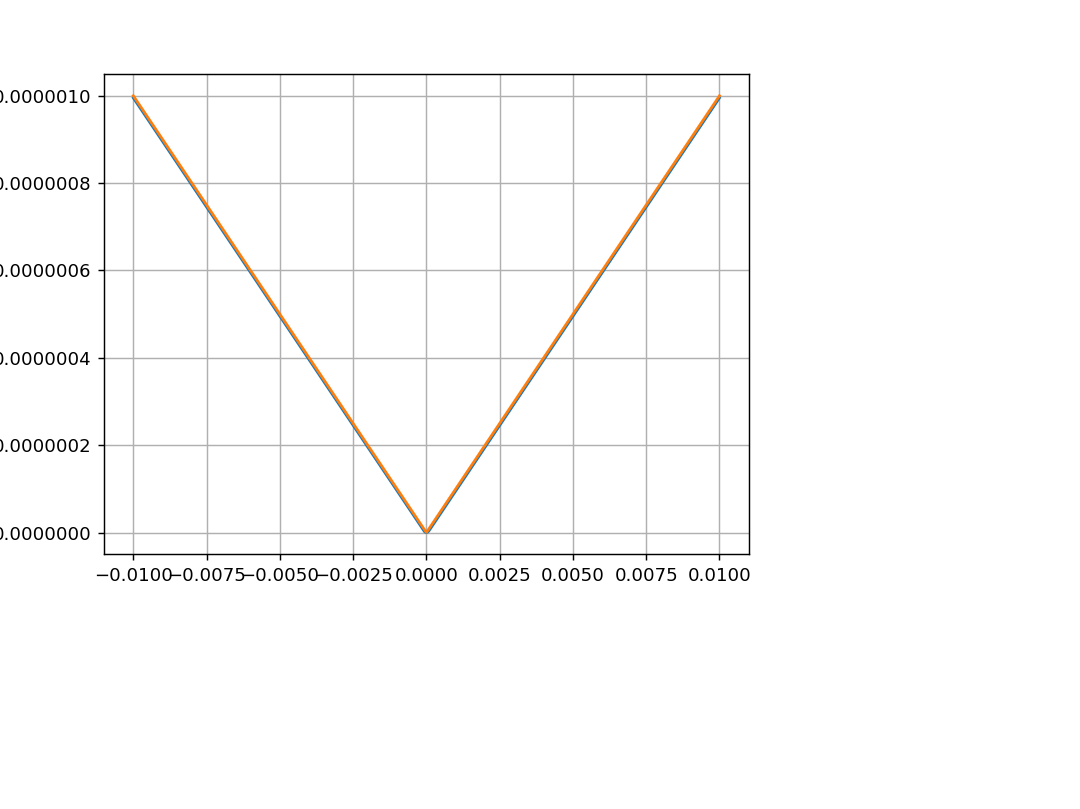

5e-09


In [23]:
tests = np.linspace(-1e-2,1e-2,1000)
h = 1e-4
y_tests = np.array([single_huber_loss(elem,h) for elem in tests])
delta_additive = 0
y_tests2 = np.array([h*np.abs(elem)+delta_additive for elem in tests])
plt.figure()
plt.grid()
plt.plot(tests,y_tests)
plt.plot(tests,y_tests2)
slack = 1/2 * h**2
print(slack)

### greedy for complex sets

## 2 : Stackelberg in game theory 

$Q$ will be the simplex set whereas $U$ will denote a norm-ball

## 3 : Progressive gradient in large scale deterministic optimization

no restriction